<a href="https://colab.research.google.com/github/CYHowo/DLproject_TextGeneration/blob/main/NEW_MODEL_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from datetime import datetime

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class CharDataset(Dataset):
    """
    Character-level dataset for language modeling.
    """
    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}
        self.block_size = block_size
        self.data = [self.stoi[ch] for ch in data]

        print(f"Vocabulary size: {len(self.stoi)}")

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx: idx + self.block_size], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1: idx + 1 + self.block_size], dtype=torch.long)
        return x, y

In [4]:
with open("shakespeare.txt", "r") as f:
    text = f.read()
block_size = 128
dataset = CharDataset(text, block_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Vocabulary size: 65


In [5]:
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, block_size, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        self.transformer_blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=4 * embed_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.output_layer = nn.Linear(embed_dim, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debug input
        token_embeddings = self.token_embedding(x)
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        position_embeddings = self.position_embedding(positions)
        x = token_embeddings + position_embeddings
        print(f"Embeddings shape: {x.shape}")  # Debug embeddings
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, embed_dim)
        x = self.transformer_blocks(x)
        x = x.permute(1, 0, 2)  # Back to (batch_size, seq_len, embed_dim)
        x = self.layer_norm(x)
        logits = self.output_layer(x)
        print(f"Logits shape: {logits.shape}")  # Debug logits
        return logits

In [6]:
vocab_size = len(dataset.stoi)
embed_dim = 128
num_heads = 4
num_layers = 4
model = GPTModel(vocab_size, embed_dim, num_heads, num_layers, block_size).to(device)
print("Model initialized.")

Model initialized.


In [7]:
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 50

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        print(f"Batch {batch_idx}: Input shape: {inputs.shape}, Target shape: {targets.shape}")  # Debug batch shapes

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))
        print(f"Batch Loss: {loss.item()}")  # Debug loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx >= 10:  # Stop early for debugging
            break

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")

Epoch 1/50
Batch 0: Input shape: torch.Size([32, 128]), Target shape: torch.Size([32, 128])
Input shape: torch.Size([32, 128])
Embeddings shape: torch.Size([32, 128, 128])
Logits shape: torch.Size([32, 128, 65])
Batch Loss: 4.320732116699219
Batch 1: Input shape: torch.Size([32, 128]), Target shape: torch.Size([32, 128])
Input shape: torch.Size([32, 128])
Embeddings shape: torch.Size([32, 128, 128])
Logits shape: torch.Size([32, 128, 65])
Batch Loss: 4.237581253051758
Batch 2: Input shape: torch.Size([32, 128]), Target shape: torch.Size([32, 128])
Input shape: torch.Size([32, 128])
Embeddings shape: torch.Size([32, 128, 128])
Logits shape: torch.Size([32, 128, 65])
Batch Loss: 4.1544575691223145
Batch 3: Input shape: torch.Size([32, 128]), Target shape: torch.Size([32, 128])
Input shape: torch.Size([32, 128])
Embeddings shape: torch.Size([32, 128, 128])
Logits shape: torch.Size([32, 128, 65])
Batch Loss: 4.091928005218506
Batch 4: Input shape: torch.Size([32, 128]), Target shape: torch

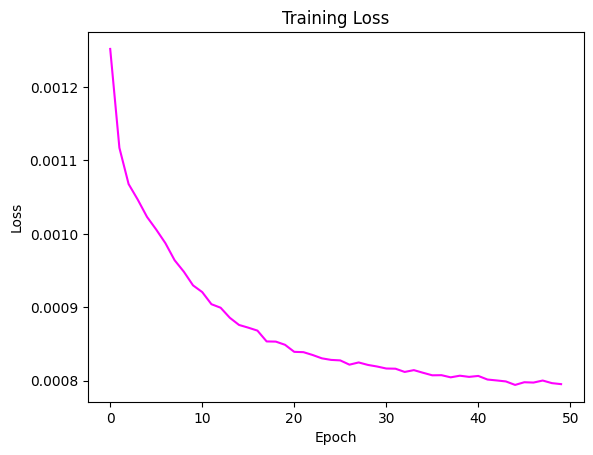

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses, c= "magenta")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [10]:
def generate_text(model, seed, max_length, temperature=1.0):
    model.eval()
    context_indices = [dataset.stoi[ch] for ch in seed]
    context = torch.tensor(context_indices, dtype=torch.long).unsqueeze(0).to(device)
    generated = seed

    for _ in range(max_length - len(seed)):
        with torch.no_grad():
            logits = model(context)[:, -1, :]
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1).item()
        generated += dataset.itos[next_idx]
        context = torch.cat([context, torch.tensor([[next_idx]], device=device)], dim=1)

    return generated

In [11]:
print("Sample Tokens:")
print(dataset[0])  # First sample

Sample Tokens:
(tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1]), tensor([47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53,
        56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,  1,
        44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1, 57,
        54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,  6,
         1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47, 58,
      

In [12]:
seed_text = "O Romeo"
print("Generated Text:")
print(generate_text(model, seed_text, max_length=50, temperature=0.8))

Generated Text:
Input shape: torch.Size([1, 7])
Embeddings shape: torch.Size([1, 7, 128])
Logits shape: torch.Size([1, 7, 65])
Input shape: torch.Size([1, 8])
Embeddings shape: torch.Size([1, 8, 128])
Logits shape: torch.Size([1, 8, 65])
Input shape: torch.Size([1, 9])
Embeddings shape: torch.Size([1, 9, 128])
Logits shape: torch.Size([1, 9, 65])
Input shape: torch.Size([1, 10])
Embeddings shape: torch.Size([1, 10, 128])
Logits shape: torch.Size([1, 10, 65])
Input shape: torch.Size([1, 11])
Embeddings shape: torch.Size([1, 11, 128])
Logits shape: torch.Size([1, 11, 65])
Input shape: torch.Size([1, 12])
Embeddings shape: torch.Size([1, 12, 128])
Logits shape: torch.Size([1, 12, 65])
Input shape: torch.Size([1, 13])
Embeddings shape: torch.Size([1, 13, 128])
Logits shape: torch.Size([1, 13, 65])
Input shape: torch.Size([1, 14])
Embeddings shape: torch.Size([1, 14, 128])
Logits shape: torch.Size([1, 14, 65])
Input shape: torch.Size([1, 15])
Embeddings shape: torch.Size([1, 15, 128])
Logit

In [13]:
torch.save(model.state_dict(), "gpt_model.pth")
model.load_state_dict(torch.load("gpt_model.pth"))

<ipython-input-13-92f812b45663>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt_model.pth"))


<All keys matched successfully>